# preprocessing

## 1.0 Create vectorizers

Plot the most common words

In [3]:
import pandas as pd
df = pd.read_csv('../data/amazon_reviews.txt', sep='\t')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text_preprocess import LemmaTokenizer

def plot_most_common_words(vectorizer, n=50):
    X = vectorizer.fit_transform(df['REVIEW_TEXT'])
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(words, counts)))
    most_common = freq_distribution.most_common(n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(15, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_most_common_words(CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None))
plot_most_common_words(TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None))

E:\PycharmProjects\amazon_fake_reviews_detection\utils\text_preprocess.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


KeyboardInterrupt: 

## 2.0 Word2Vec

In [1]:
from nltk import sent_tokenize
import time
import json
import glob
import os

# Read each JSONL file and append to the list
def create_sentences():
    for file in glob.glob('../data/word2vec/*.jsonl'):

        print("Processing file: " + file)
        sentences = set()
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data = json.loads(line)
                    if 'timestamp' in data and 'text' in data:
                        timestamp = pd.to_datetime(data['timestamp'], unit='ms')
                        if timestamp < pd.Timestamp('2019-01-01'):
                            sentences.update(set(sent_tokenize(data['text'])))
                except json.JSONDecodeError:
                    print(f"Skipping bad line in file {file}")
    
        with open('../data/word2vec_processed/sentences.txt', 'a', encoding='utf-8') as f:
            for sentence in sentences:
                if len(sentence) > 2:
                    f.write(sentence + '\n')

if not os.path.exists('../data/word2vec_processed/sentences.txt'):
    create_sentences()

Process the sentences and tokenize them

In [ ]:
import os
from utils.text_preprocess import LemmaTokenizer

if os.path.exists('../data/word2vec_processed/sentences_tokenized.txt'):
    raise KeyboardInterrupt 
    
with open('../data/word2vec_processed/sentences.txt', 'r', encoding='utf-8') as f1:
    with open('../data/word2vec_processed/sentences_tokenized.txt', 'a', encoding='utf-8') as f2:
        for line in f1:
            tokens = LemmaTokenizer()(line)
            if len(tokens) > 0:
                f2.write(' '.join(tokens) + '\n')
                

E:\PycharmProjects\amazon_fake_reviews_detection\utils\text_preprocess.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Plot the 1000 most frequent and least frequent words

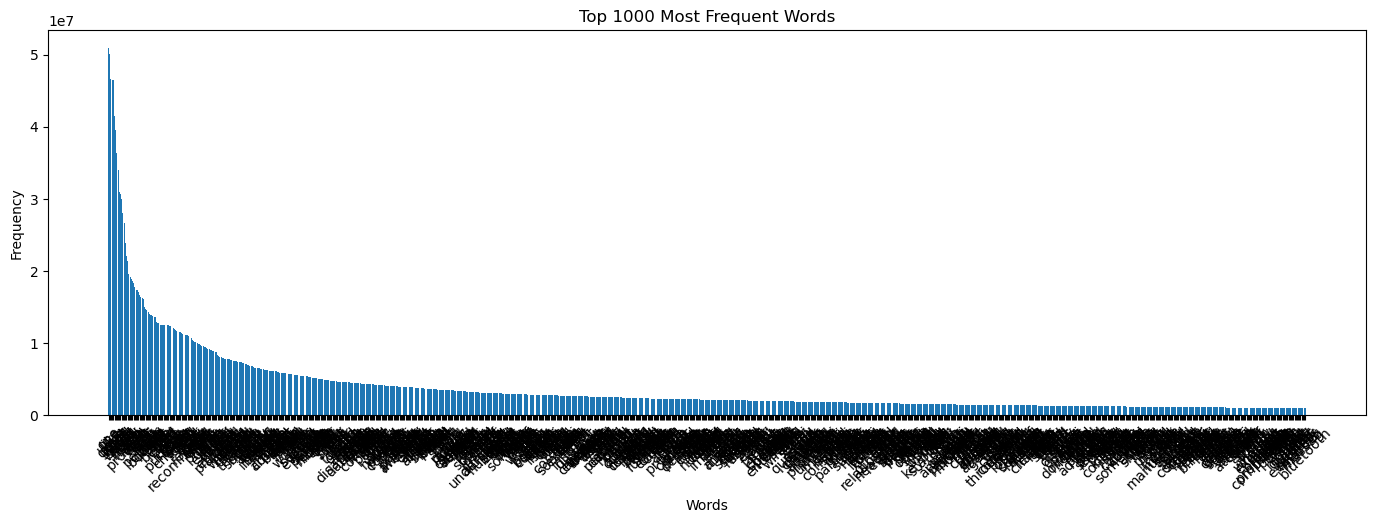

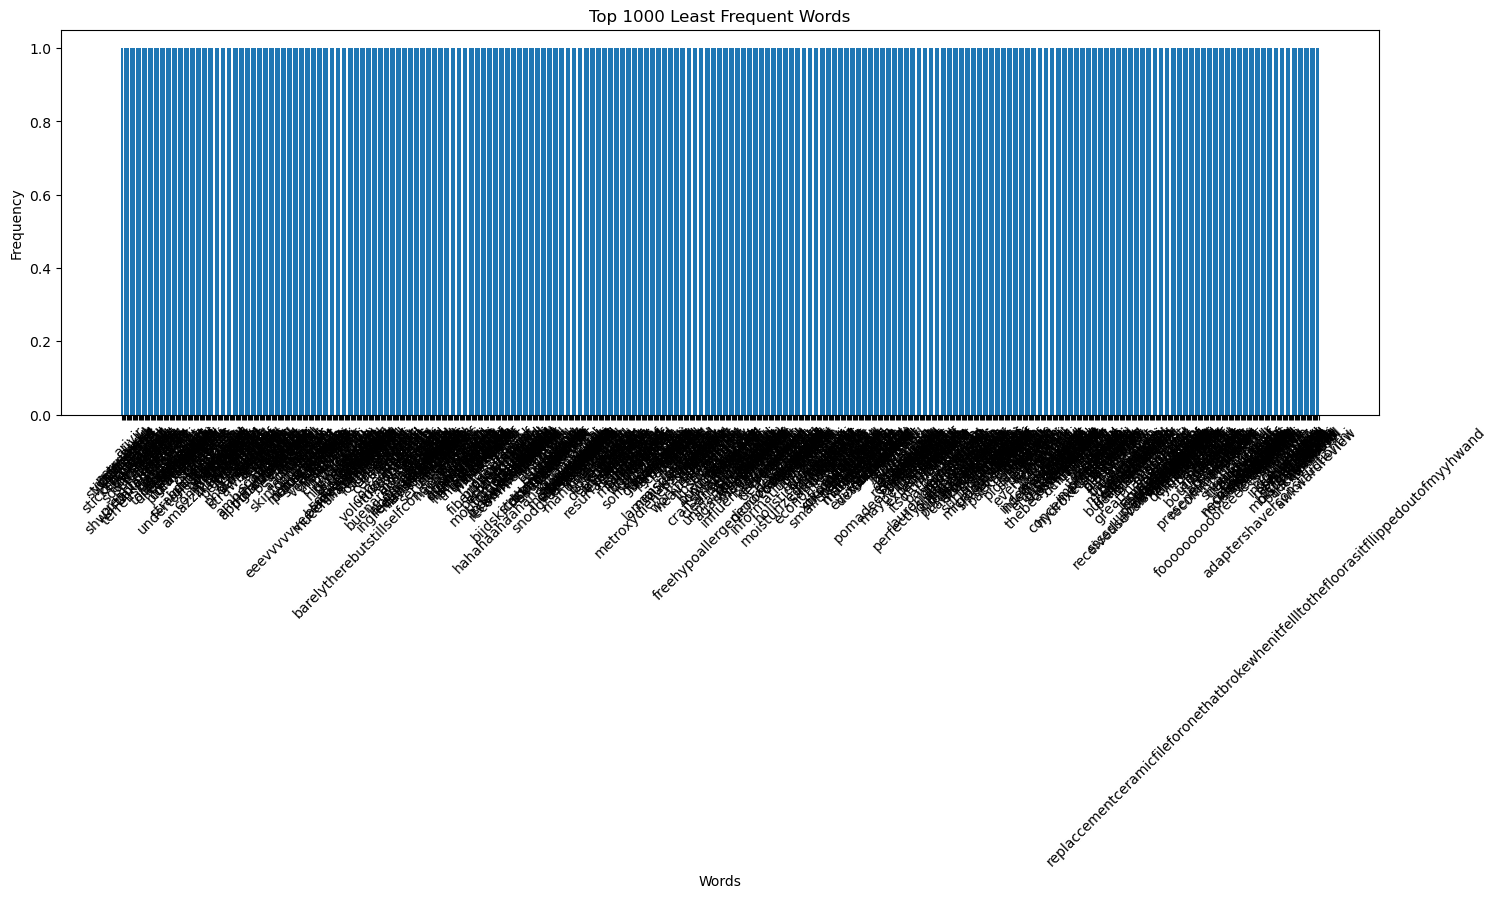

In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
from collections import Counter
import heapq

def process_chunk(chunk):
    word_counter = Counter()
    lines = chunk.splitlines()
    for line in lines:
        words = line.split()
        word_counter.update(words)
    return word_counter


def count_words_in_parallel(file_path, chunk_size, num_workers=1):
    word_counter = Counter()
    
    with open(file_path, 'r') as file:
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = []
            while True:
                chunk = file.read(chunk_size)
                if not chunk:
                    break
                # Submit each chunk to be processed in parallel
                futures.append(executor.submit(process_chunk, chunk))
            
            # Combine results from all workers
            for future in concurrent.futures.as_completed(futures):
                word_counter.update(future.result())
    
    return word_counter


def plot_word_frequency(word_counter, n=1000):

    most_common = heapq.nlargest(n, word_counter.items(), key=lambda x: x[1])
    words, frequencies = zip(*most_common)
    
    plt.figure(figsize=(17, 5))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45)

    plt.title(f'Top {n} Most Frequent Words')
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

file_path = '../data/word2vec_processed/sentences_tokenized.txt'  # Change to your file's path
word_counter = count_words_in_parallel(file_path, chunk_size=1024 * 1024 * 500, num_workers=20)
plot_word_frequency(word_counter, n=1000)

Train Word2Vec model

In [5]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from utils.word2vec_callback import Word2VecProgress
import time

# Skip-gram model (sg = 1)
size = 100
window = 5
min_count = 500000
print(f"number of cores: {cpu_count()}")
workers = cpu_count()
sg = 1
# ========= Train the Word2Vec model =========
word2vec_model_file =  '../models/word2vec_' + str(size) + '_v2.model'
print("Training Word2Vec Model")
start_time = time.time()
            
# Train the Word2Vec Model
w2v_model = Word2Vec(corpus_file='../data/word2vec_processed/sentences_tokenized.txt', 
                     min_count = min_count,
                     vector_size = size,
                     workers = workers, 
                     window = window, 
                     sg = sg,
                     callbacks=[Word2VecProgress()])
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

number of cores: 20
Training Word2Vec Model
Epoch #0 start
Epoch #0 end
Time taken for this epoch: 5388.62s
Epoch #1 start
Epoch #1 end
Time taken for this epoch: 4281.64s
Epoch #2 start
Epoch #2 end
Time taken for this epoch: 3350.62s
Epoch #3 start
Epoch #3 end
Time taken for this epoch: 4281.42s
Epoch #4 start
Epoch #4 end
Time taken for this epoch: 4218.77s
Time taken to train word2vec model: 21521.102416992188


Plot the word2vec model

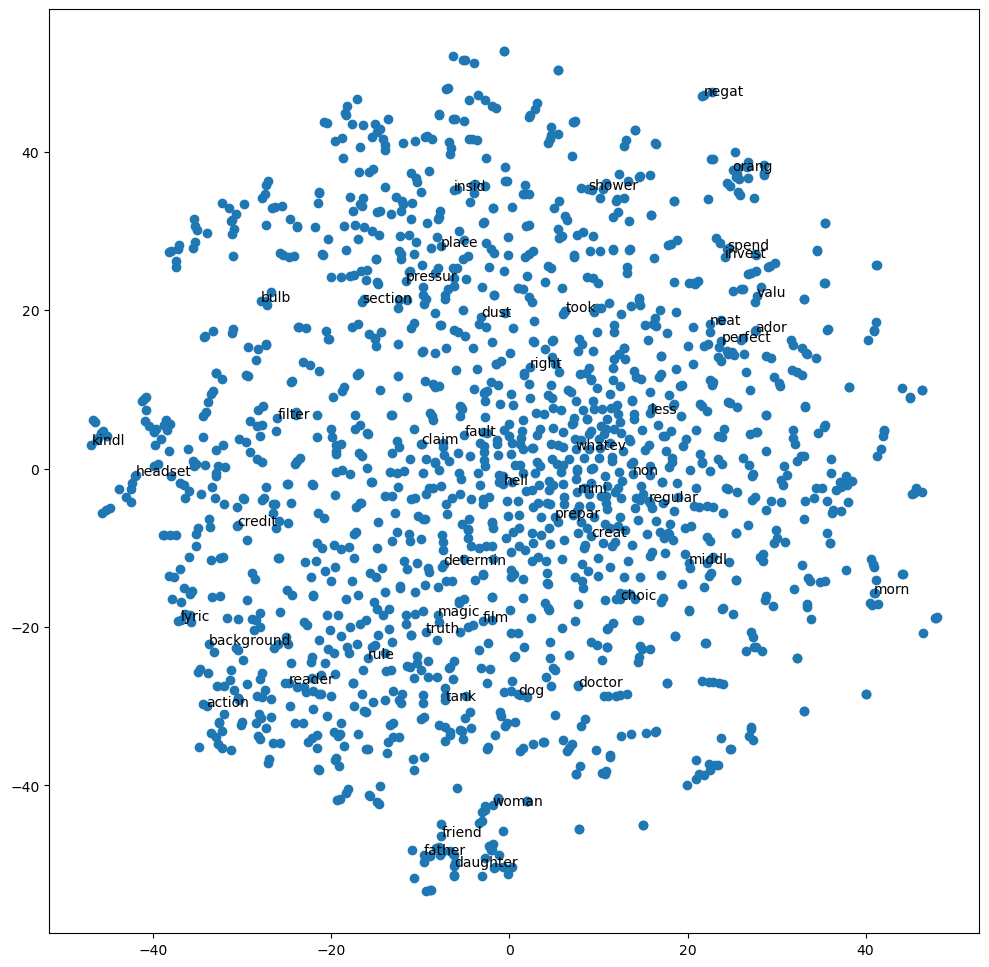

In [8]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np    
from gensim.models import Word2Vec
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import random

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


word2vec_model_file =  '../models/word2vec_100_v2.model'
model = Word2Vec.load(word2vec_model_file)
x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')
        
        
random.seed(0)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)
#
# Label randomly subsampled 25 data points
#
indices = list(range(len(labels)))
selected_indices = random.sample(indices, 50)
for i in selected_indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
plt.show()